In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

import numpy as np
from tqdm import tqdm
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
from moving_average import moving_average_1d

import importlib
import policy
importlib.reload(policy)
from policy import PolicyNN

from nn_functions import surrogate

import sys
sys.path.append('../1_model')
from TiDE import TideModule, quantile_loss  


cuda is available


In [2]:
import torch
import pickle

# Load model
with open('TiDE_params_single_track_square_MV_temp_depth_less_cov_0915_w50_p50.pkl', 'rb') as file:
    nominal_params = pickle.load(file)

TiDE = nominal_params['model'].to(device)
total_params = sum(p.numel() for p in TiDE.parameters())

In [7]:
import pandas as pd
import numpy as np
import copy

# Load data
df_all = pd.read_csv('../0_data/merged_df_2_99_temp_depth.csv').dropna()

# Extract input features
loc_Z = df_all["Z"].to_numpy().reshape(-1, 1)
dist_X = df_all["Dist_to_nearest_X"].to_numpy().reshape(-1, 1)
dist_Y = df_all["Dist_to_nearest_Y"].to_numpy().reshape(-1, 1)
laser_power = df_all["Laser_power"].to_numpy().reshape(-1, 1)

mp_temp = df_all["melt_pool_temperature"].to_numpy()
mp_temp[1:-2] = moving_average_1d(mp_temp, 4)
mp_temp = mp_temp.reshape(-1, 1)

mp_depth = df_all["melt_pool_depth"].to_numpy()
mp_depth[1:-2] = moving_average_1d(mp_depth, 4)
mp_depth = mp_depth.reshape(-1, 1)

# Combine inputs and outputs
x_original = np.concatenate([loc_Z, dist_X, dist_Y, laser_power], axis=1)
y_original = np.concatenate([mp_temp, mp_depth], axis=1)

# Define fixed global min/max
x_max = np.array([[7.5, 20.0, 20.0, 732.298]])
x_min = np.array([[0.0, 0.75, 0.75, 504.26]])
y_max = np.array([[4509.855, 0.551]])
y_min = np.array([[436.608, -0.559]])

# Define scaler class
class scalers:
    def __init__(self, x_max, x_min, y_max, y_min):
        self.x_max = x_max
        self.x_min = x_min
        self.y_max = y_max
        self.y_min = y_min

    def scaler_x(self, x): return -1 + 2 * (x - self.x_min) / (self.x_max - self.x_min)
    def scaler_y(self, y): return -1 + 2 * (y - self.y_min) / (self.y_max - self.y_min)
    def inv_scaler_y(self, y): return 0.5 * (y + 1) * (self.y_max - self.y_min) + self.y_min

# Apply scaling
scaler = scalers(x_max, x_min, y_max, y_min)
x_s = scaler.scaler_x(x_original)
y_s = scaler.scaler_y(y_original)


In [8]:
import torch
from tqdm import tqdm
import os

window = 50
P = 50
sample_fraction = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sample valid sequences
valid_indices = list(range(window, x_s.shape[0] - P))
sample_size = max(1, int(len(valid_indices) * sample_fraction))
sampled_indices = np.random.choice(valid_indices, size=sample_size, replace=False)

# Prepare sequences
x_past_all = np.stack([x_s[i-window:i] for i in sampled_indices])
y_past_all = np.stack([y_s[i-window:i] for i in sampled_indices])
x_future_all = np.stack([x_s[i:i+P] for i in sampled_indices])
y_target_all = np.stack([y_s[i:i+P] for i in sampled_indices])

# Convert to tensors
x_past = torch.tensor(x_past_all, dtype=torch.float32).to(device)
y_past = torch.tensor(y_past_all, dtype=torch.float32).to(device)
x_future = torch.tensor(x_future_all, dtype=torch.float32).to(device)
y_target = torch.tensor(y_target_all, dtype=torch.float32)  # on CPU


In [9]:
# ── 누적 리스트 초기화 ───────────────────────────────
true_temp_all = []
pred_temp_all = []
true_depth_all = []
pred_depth_all = []

TiDE.eval()

for i in tqdm(range(sample_size), desc="Evaluating TiDE"):
    past_cov = torch.cat((y_past[i:i+1], x_past[i:i+1]), dim=2)     # [1, 50, 6]
    x_future_tide = torch.cat((x_future[i:i+1, :, :3], x_future[i:i+1, :, 3:]), dim=2)  # [1, 50, 4]

    with torch.no_grad():
        y_pred_all = TiDE((past_cov, x_future_tide, None))         # [1, 50, quantiles, 3]

    y_pred_norm = y_pred_all[:, :, :, 1].squeeze(0).cpu().numpy()
    y_true_norm = y_target[i].numpy()

    y_pred_denorm = scaler.inv_scaler_y(y_pred_norm)  # [50, 2]
    y_true_denorm = scaler.inv_scaler_y(y_true_norm)  # [50, 2]

    # 🔽 리스트에 누적
    true_temp_all.append(y_true_denorm[:, 0])
    true_depth_all.append(y_true_denorm[:, 1])
    pred_temp_all.append(y_pred_denorm[:, 0])
    pred_depth_all.append(y_pred_denorm[:, 1])


Evaluating TiDE: 100%|██████████| 61031/61031 [00:53<00:00, 1144.75it/s]


In [10]:
# [N_samples * 50] 형태로 결합
true_temp_all = np.concatenate(true_temp_all)
pred_temp_all = np.concatenate(pred_temp_all)
true_depth_all = np.concatenate(true_depth_all)
pred_depth_all = np.concatenate(pred_depth_all)

def compute_metrics(true, pred):
    mae = np.mean(np.abs(true - pred))
    rmse = np.sqrt(np.mean((true - pred) ** 2))
    return mae, rmse

mae_temp, rmse_temp = compute_metrics(true_temp_all, pred_temp_all)
mae_depth, rmse_depth = compute_metrics(true_depth_all, pred_depth_all)

print("📊 Temperature:")
print(f"  MAE  = {mae_temp:.4f}")
print(f"  RMSE = {rmse_temp:.4f}")

print("\n📊 Depth:")
print(f"  MAE  = {mae_depth:.4f}")
print(f"  RMSE = {rmse_depth:.4f}")


📊 Temperature:
  MAE  = 17.7025
  RMSE = 35.0347

📊 Depth:
  MAE  = 0.0105
  RMSE = 0.0167


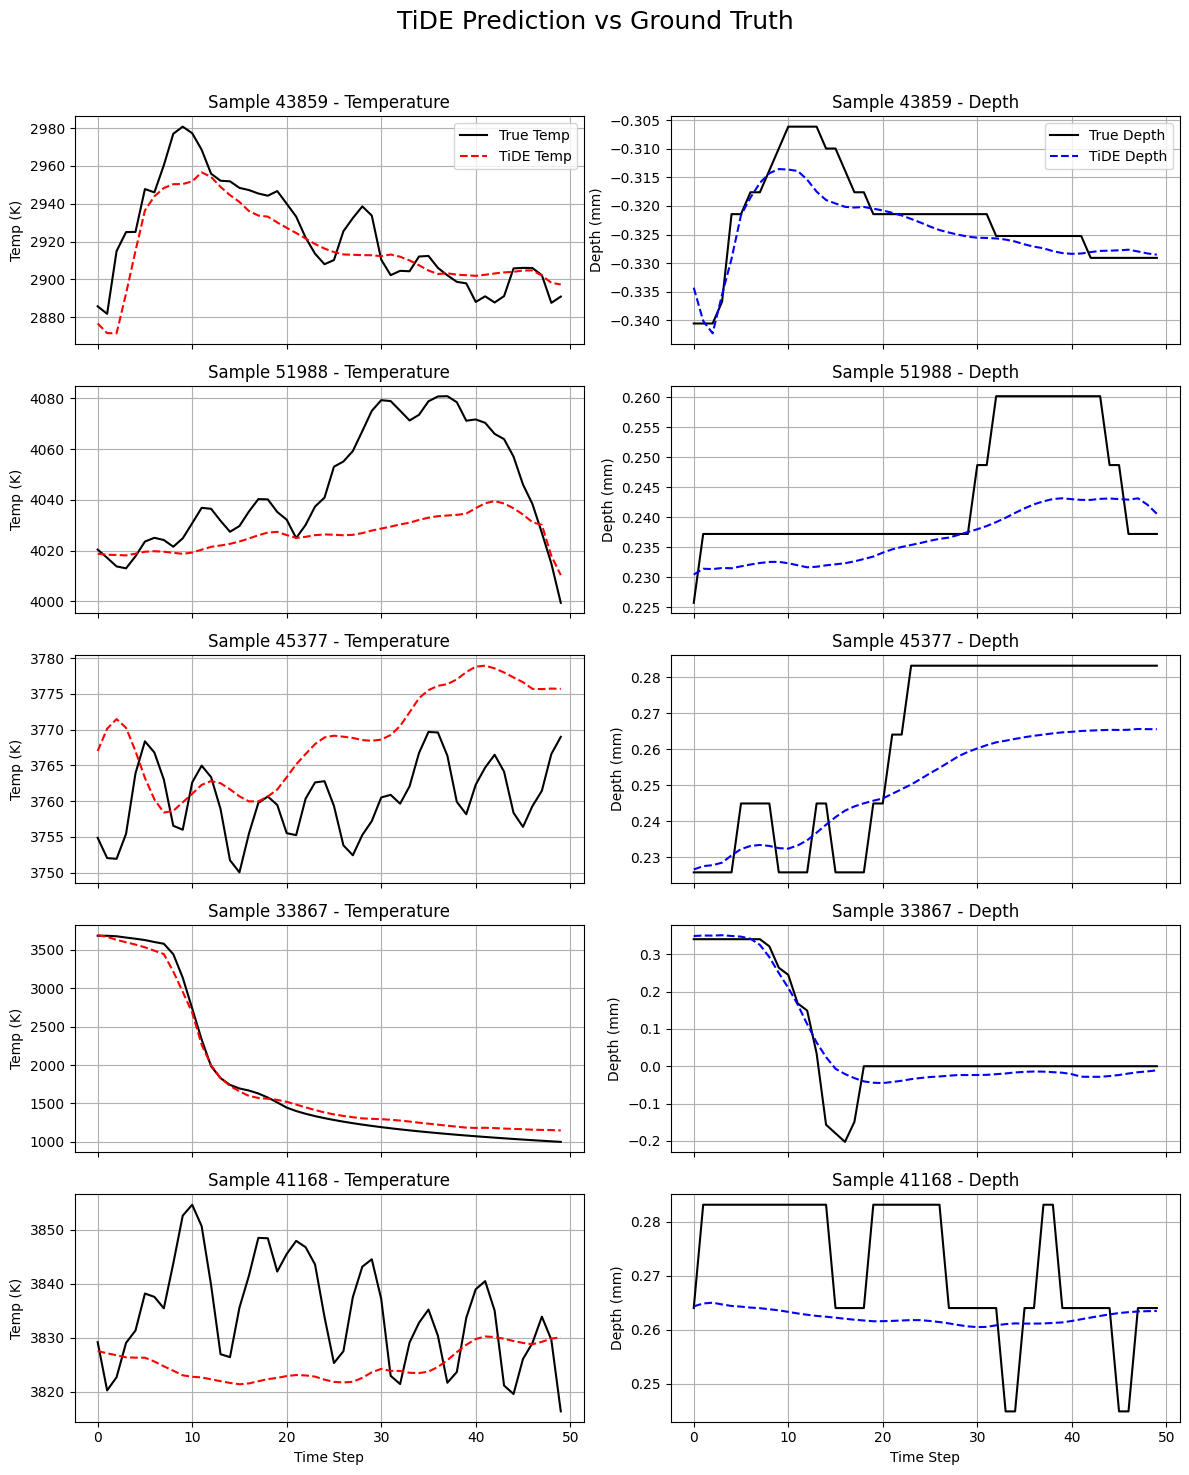

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import random

# ── 무작위 샘플 선택 ─────────────────────────────
num_samples_to_plot = 5
sample_indices = random.sample(range(len(true_temp_all) // 50), num_samples_to_plot)

fig, axs = plt.subplots(num_samples_to_plot, 2, figsize=(12, 3 * num_samples_to_plot), sharex='col')
fig.suptitle("TiDE Prediction vs Ground Truth", fontsize=18)

# 1개일 경우 2D로 강제 reshape
if num_samples_to_plot == 1:
    axs = np.array([axs])

for row, idx in enumerate(sample_indices):
    # 추출된 50개 시퀀스
    y_true_temp = true_temp_all[idx*50:(idx+1)*50]
    y_pred_temp = pred_temp_all[idx*50:(idx+1)*50]
    y_true_depth = true_depth_all[idx*50:(idx+1)*50]
    y_pred_depth = pred_depth_all[idx*50:(idx+1)*50]

    # ─ Temperature plot ─
    ax_temp = axs[row, 0]
    ax_temp.plot(y_true_temp, label="True Temp", color="black")
    ax_temp.plot(y_pred_temp, label="TiDE Temp", color="red", linestyle="--")
    ax_temp.set_ylabel("Temp (K)")
    ax_temp.set_title(f"Sample {idx} - Temperature")
    ax_temp.grid(True)
    if row == 0:
        ax_temp.legend()

    # ─ Depth plot ─
    ax_depth = axs[row, 1]
    ax_depth.plot(y_true_depth, label="True Depth", color="black")
    ax_depth.plot(y_pred_depth, label="TiDE Depth", color="blue", linestyle="--")
    ax_depth.set_ylabel("Depth (mm)")
    ax_depth.set_title(f"Sample {idx} - Depth")
    ax_depth.grid(True)
    if row == 0:
        ax_depth.legend()

axs[-1, 0].set_xlabel("Time Step")
axs[-1, 1].set_xlabel("Time Step")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [14]:
import os
import pandas as pd
from tqdm import tqdm

# ── 경로 설정 ─────────────────────────────────────
load_dir = "/home/ftk3187/github/DPC_research/02_DED/4_policy_0725/simulation_outputs_case21_discrete shift"

# ── 대상 파일 리스트 ──────────────────────────────
x_output_files = sorted([
    f for f in os.listdir(load_dir) 
    if f.startswith("x_outputs_laser_") and f.endswith(".csv")
])

# ── 파일 불러와서 하나의 DataFrame으로 통합 ───────
all_data = []

for fname in tqdm(x_output_files):
    full_path = os.path.join(load_dir, fname)
    df = pd.read_csv(full_path, header=None)  # 열 이름 없이 읽기

    # ─ 열 이름 수동 지정 ─
    df.columns = ["Melt Pool Temp", "Melt Pool Depth"]

    # ─ laser_power_number 추출 ─
    laser_num = int(fname.split("_")[-1].split(".")[0])
    
    # ─ time_index 열 추가 ─
    df["time_index"] = df.index
    df["laser_power_number"] = laser_num
    
    all_data.append(df)

# ── 통합 데이터프레임 생성 ────────────────────────
df_all_x_outputs = pd.concat(all_data, ignore_index=True)
print("전체 데이터 shape:", df_all_x_outputs.shape)
print(df_all_x_outputs.head())

# ── 조건 필터링: time_index ∈ [2490, 6080] ───────────────
filtered_df = df_all_x_outputs[
    (df_all_x_outputs["time_index"] >= 2490) & 
    (df_all_x_outputs["time_index"] <= 6080)
].reset_index(drop=True)

print("필터링된 데이터 shape:", filtered_df.shape)
print(filtered_df.head())

# ❌ CSV 저장 제거
# filtered_df.to_csv(...) 제거


100%|██████████| 33/33 [00:00<00:00, 470.05it/s]

전체 데이터 shape: (206118, 4)
   Melt Pool Temp  Melt Pool Depth  time_index  laser_power_number
0        0.000000         1.000000           0                  15
1      400.000000         0.000000           1                  15
2      400.000000         0.000000           2                  15
3      469.194519         0.000000           3                  15
4     1127.675415        -0.330612           4                  15
필터링된 데이터 shape: (118503, 4)
   Melt Pool Temp  Melt Pool Depth  time_index  laser_power_number
0     3471.771785         0.214286        2490                  15
1     3449.371600         0.207398        2491                  15
2     3449.228104         0.186735        2492                  15
3     3457.330012         0.179847        2493                  15
4     3466.957096         0.179847        2494                  15


📊 평균 (mean): -0.015939
📈 표준편차 (std): 0.027896


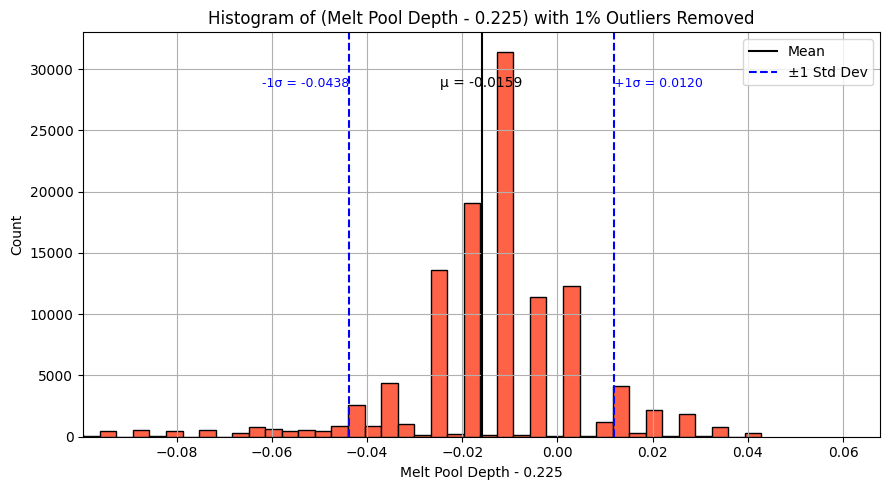

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# ── 컬럼 이름 고정 ─────────────────────────────────────
second_col_name = "Melt Pool Depth"
adjusted_values = filtered_df[second_col_name].values - 0.225

# ── 아웃라이어 제거 (1%, 99%) ─────────────────────────
lower_bound = np.percentile(adjusted_values, 1)
upper_bound = np.percentile(adjusted_values, 99)

cleaned_values = adjusted_values[
    (adjusted_values >= lower_bound) & (adjusted_values <= upper_bound)
]

# ── 평균 및 표준편차 계산 ─────────────────────────────
mean_val = np.mean(cleaned_values)
std_val = np.std(cleaned_values)

print(f"📊 평균 (mean): {mean_val:.6f}")
print(f"📈 표준편차 (std): {std_val:.6f}")

# ── 히스토그램 시각화 ─────────────────────────────────
plt.figure(figsize=(9, 5))
n, bins, _ = plt.hist(cleaned_values, bins=100, color='tomato', edgecolor='black')

# ─ 평균 및 ±1σ 수직선 ────────────────────────────────
plt.axvline(mean_val, color='black', linestyle='-', label='Mean')
plt.axvline(mean_val - std_val, color='blue', linestyle='--', label='±1 Std Dev')
plt.axvline(mean_val + std_val, color='blue', linestyle='--')

# ─ 값 텍스트로 그래프 안에 표시 ─────────────────────
ymax = max(n)
text_y = ymax * 0.9

plt.text(mean_val, text_y, f"μ = {mean_val:.4f}", color='black', fontsize=10, ha='center', va='bottom')
plt.text(mean_val - std_val, text_y, f"-1σ = {mean_val - std_val:.4f}", color='blue', fontsize=9, ha='right', va='bottom')
plt.text(mean_val + std_val, text_y, f"+1σ = {mean_val + std_val:.4f}", color='blue', fontsize=9, ha='left', va='bottom')

# ─ x축 범위: ±3σ ─────────────────────────────────────
plt.xlim(mean_val - 3 * std_val, mean_val + 3 * std_val)

# ─ 기타 스타일 ───────────────────────────────────────
plt.title(f"Histogram of ({second_col_name} - 0.225) with 1% Outliers Removed")
plt.xlabel(f"{second_col_name} - 0.225")
plt.ylabel("Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


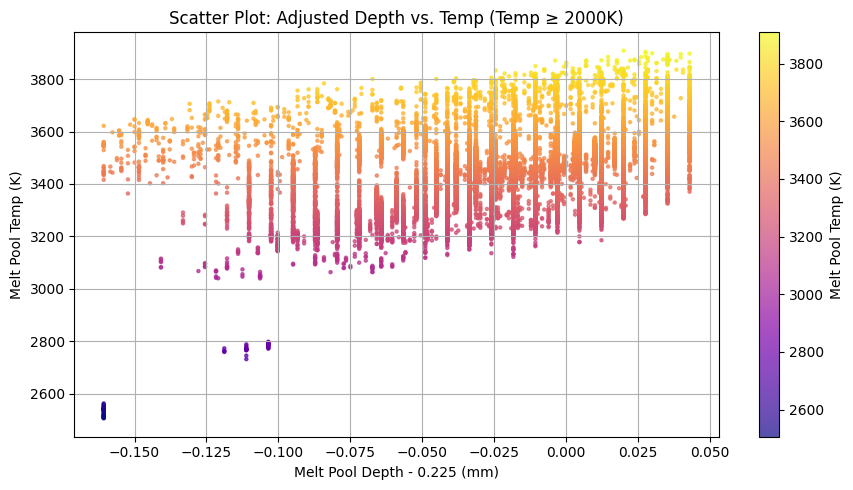

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# ─ 원본 데이터 불러오기 ─────────────────────────────
depth = filtered_df["Melt Pool Depth"].values - 0.225
temp = filtered_df["Melt Pool Temp"].values

# ─ 조건 필터링 ──────────────────────────────────────
mask_temp = (temp >= 2500)

# depth 기준 아웃라이어 제거 (1%~99%) on filtered temp
depth_temp_filtered = depth[mask_temp]
temp_filtered = temp[mask_temp]

lower_bound = np.percentile(depth_temp_filtered, 1)
upper_bound = np.percentile(depth_temp_filtered, 99)

mask_depth = (depth_temp_filtered >= lower_bound) & (depth_temp_filtered <= upper_bound)

# 최종 필터링된 값
final_depth = depth_temp_filtered[mask_depth]
final_temp = temp_filtered[mask_depth]

# ─ 산점도 시각화 ─────────────────────────────────────
plt.figure(figsize=(9, 5))
sc = plt.scatter(
    final_depth, final_temp,
    c=final_temp, cmap='plasma', alpha=0.7, s=5
)

plt.colorbar(sc, label="Melt Pool Temp (K)")
plt.xlabel("Melt Pool Depth - 0.225 (mm)")
plt.ylabel("Melt Pool Temp (K)")
plt.title("Scatter Plot: Adjusted Depth vs. Temp (Temp ≥ 2000K)")
plt.grid(True)
plt.tight_layout()
plt.show()
